# Yield Curve Construction and Bond Pricing
This notebook demonstrates:-
- Bootstrapping yield curves from bond prices
- Comparing different interpolation methods
- Pricing bonds using yield curves
- Calculating bond analytics (duration, convexity)
- Forward rate calculationsYield curves are fundamental to fixed income analysis, providing the term structure of interest rates.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dervflow import YieldCurve, YieldCurveBuilder, BondAnalytics

plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline
import time

## 1. Market Data: Bond PricesWe'll start with a set of Treasury bonds with known prices and use them to bootstrap a yield curve.

In [2]:
# Define bond market data
# Format: maturity (years), coupon rate (decimal), price, payment frequency
bond_data = [
    {"maturity": 0.25, "coupon": 0.0000, "price": 99.50, "frequency": 4},  # 3-month T-bill
    {"maturity": 0.50, "coupon": 0.0000, "price": 98.75, "frequency": 2},  # 6-month T-bill
    {"maturity": 1.00, "coupon": 0.0250, "price": 100.25, "frequency": 2},  # 1-year note
    {"maturity": 2.00, "coupon": 0.0300, "price": 101.50, "frequency": 2},  # 2-year note
    {"maturity": 3.00, "coupon": 0.0325, "price": 102.00, "frequency": 2},  # 3-year note
    {"maturity": 5.00, "coupon": 0.0350, "price": 102.75, "frequency": 2},  # 5-year note
    {"maturity": 7.00, "coupon": 0.0375, "price": 103.25, "frequency": 2},  # 7-year note
    {"maturity": 10.0, "coupon": 0.0400, "price": 104.00, "frequency": 2},  # 10-year note
    {"maturity": 20.0, "coupon": 0.0425, "price": 105.50, "frequency": 2},  # 20-year bond
    {"maturity": 30.0, "coupon": 0.0450, "price": 106.75, "frequency": 2},  # 30-year bond
]

# Display bond data with coupon rates in percent
df_bonds = pd.DataFrame(bond_data)
df_bonds["coupon_percent"] = df_bonds["coupon"] * 100
print("Market Bond Data:")
print(
    df_bonds[["maturity", "coupon_percent", "price", "frequency"]]
    .rename(columns={"coupon_percent": "coupon (%)"})
    .to_string(index=False)
)

Market Bond Data:
 maturity  coupon (%)  price  frequency
     0.25        0.00  99.50          4
     0.50        0.00  98.75          2
     1.00        2.50 100.25          2
     2.00        3.00 101.50          2
     3.00        3.25 102.00          2
     5.00        3.50 102.75          2
     7.00        3.75 103.25          2
    10.00        4.00 104.00          2
    20.00        4.25 105.50          2
    30.00        4.50 106.75          2


## 2. Bootstrap Yield CurveBootstrap zero-coupon rates from the bond prices using the YieldCurveBuilder.

In [3]:
# Bootstrap yield curve from bond data
builder = YieldCurveBuilder()
bonds_input = [(b["maturity"], b["coupon"], b["price"], b["frequency"]) for b in bond_data]

start_time = time.time()
yield_curve = builder.bootstrap_from_bonds(bonds_input)
bootstrap_time = time.time() - start_time
print(f"Yield curve bootstrapped in {bootstrap_time*1000:.2f} ms")
print(f"Number of points: {len(bond_data)}")

Yield curve bootstrapped in 0.41 ms
Number of points: 10


## 3. Compare Interpolation MethodsDifferent interpolation methods can produce different yield curves. Let's compare:- Linear interpolation- Cubic spline interpolation- Nelson-Siegel model

In [4]:
# Create yield curves with different interpolation methods
maturities = np.array([b["maturity"] for b in bond_data], dtype=float)
# Extract zero rates from bootstrapped curve
zero_rates = np.array([yield_curve.zero_rate(m) for m in maturities], dtype=float)
# Create curves with different interpolation
curve_linear = YieldCurve(maturities, zero_rates, method="linear")
curve_cubic = YieldCurve(maturities, zero_rates, method="cubic_spline_natural")
curve_ns = YieldCurve(maturities, zero_rates, method="nelson_siegel")
print("Yield curves created with different interpolation methods")

Yield curves created with different interpolation methods


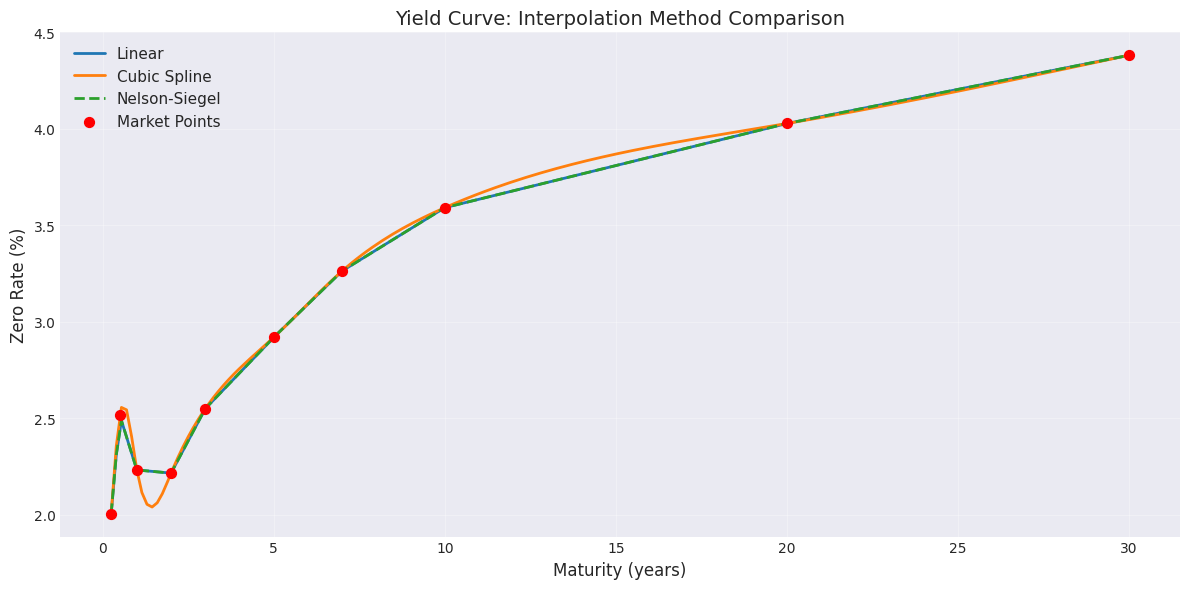

In [5]:
# Plot yield curves with different interpolation
fine_maturities = np.linspace(0.25, 30, 200)
rates_linear = [curve_linear.zero_rate(m) for m in fine_maturities]
rates_cubic = [curve_cubic.zero_rate(m) for m in fine_maturities]
rates_ns = [curve_ns.zero_rate(m) for m in fine_maturities]

plt.figure(figsize=(12, 6))
plt.plot(fine_maturities, np.array(rates_linear) * 100, label="Linear", linewidth=2)
plt.plot(fine_maturities, np.array(rates_cubic) * 100, label="Cubic Spline", linewidth=2)
plt.plot(
    fine_maturities, np.array(rates_ns) * 100, label="Nelson-Siegel", linewidth=2, linestyle="--"
)
plt.scatter(
    maturities, np.array(zero_rates) * 100, color="red", s=50, zorder=5, label="Market Points"
)
plt.xlabel("Maturity (years)", fontsize=12)
plt.ylabel("Zero Rate (%)", fontsize=12)
plt.title("Yield Curve: Interpolation Method Comparison", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Forward Rate CalculationsForward rates represent the market's expectation of future interest rates.

In [6]:
# Calculate forward rates
forward_periods = [(0, 1), (1, 2), (2, 3), (3, 5), (5, 7), (7, 10), (10, 20), (20, 30)]
forward_rates = []
print("Forward Rates:")
print(f"{'Period':<15} {'Forward Rate':<15}")
print("-" * 30)
for t1, t2 in forward_periods:
    fwd_rate = yield_curve.forward_rate(t1, t2)
    forward_rates.append(fwd_rate)
    print(f"{t1}Y - {t2}Y{'':<7} {fwd_rate*100:>6.3f}%")

Forward Rates:
Period          Forward Rate   
------------------------------
0Y - 1Y         2.232%
1Y - 2Y         2.199%
2Y - 3Y         3.218%
3Y - 5Y         3.473%
5Y - 7Y         4.124%
7Y - 10Y         4.357%
10Y - 20Y         4.464%
20Y - 30Y         5.089%


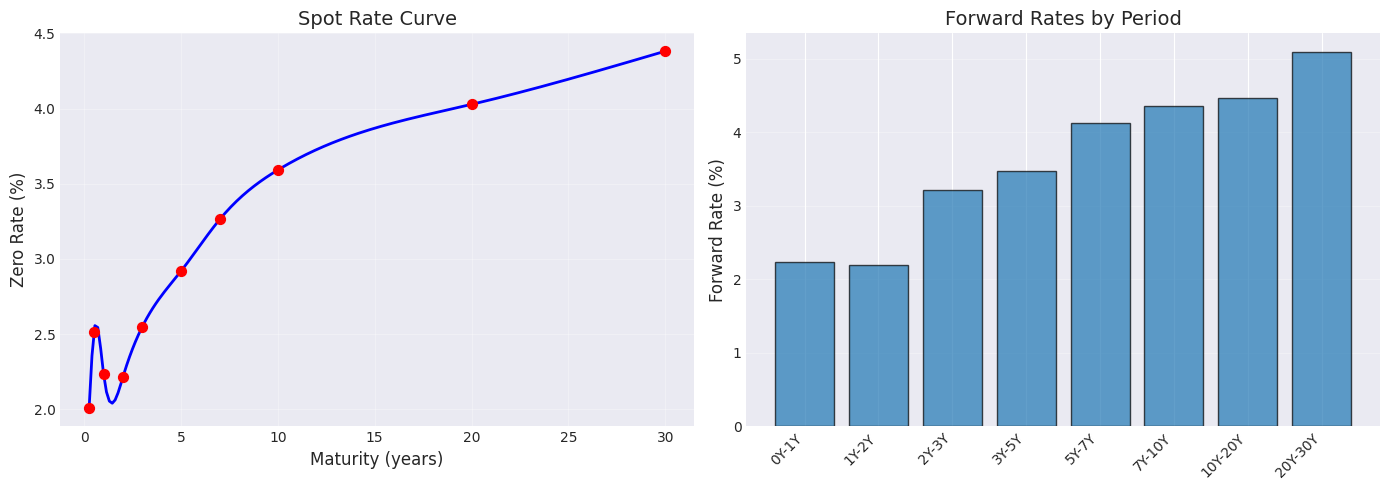

In [7]:
# Visualize spot vs forward rates
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Spot rates
ax1.plot(fine_maturities, np.array(rates_cubic) * 100, linewidth=2, color="blue")
ax1.scatter(maturities, np.array(zero_rates) * 100, color="red", s=50, zorder=5)
ax1.set_xlabel("Maturity (years)", fontsize=12)
ax1.set_ylabel("Zero Rate (%)", fontsize=12)
ax1.set_title("Spot Rate Curve", fontsize=14)
ax1.grid(True, alpha=0.3)

# Forward rates
period_labels = [f"{t1}Y-{t2}Y" for t1, t2 in forward_periods]
ax2.bar(range(len(forward_rates)), np.array(forward_rates) * 100, alpha=0.7, edgecolor="black")
ax2.set_xticks(range(len(forward_rates)))
ax2.set_xticklabels(period_labels, rotation=45, ha="right")
ax2.set_ylabel("Forward Rate (%)", fontsize=12)
ax2.set_title("Forward Rates by Period", fontsize=14)
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## 5. Price Bonds Using Yield CurveUse the yield curve to price bonds and verify against market prices.

In [8]:
# Price bonds using the yield curve
analytics = BondAnalytics()

print("Bond Pricing Verification:")
print(f"{'Maturity':<10} {'Market Price':<15} {'Model Price':<15} {'Error':<10}")
print("-" * 50)
for bond in bond_data:
    maturity = bond["maturity"]
    coupon = bond["coupon"]
    freq = bond["frequency"]
    market_price = bond["price"]

    cashflows = analytics.generate_cashflows(maturity, coupon, 100.0, freq)
    model_price = yield_curve.price_bond(cashflows)
    error = model_price - market_price

    print(f"{maturity:<10.2f} {market_price:<15.4f} {model_price:<15.4f} {error:<10.4f}")

Bond Pricing Verification:
Maturity   Market Price    Model Price     Error     
--------------------------------------------------
0.25       99.5000         99.5000         0.0000    
0.50       98.7500         98.7500         0.0000    
1.00       100.2500        100.2500        0.0000    
2.00       101.5000        101.5002        0.0002    
3.00       102.0000        101.9936        -0.0064   
5.00       102.7500        102.7138        -0.0362   
7.00       103.2500        103.2005        -0.0495   
10.00      104.0000        103.8925        -0.1075   
20.00      105.5000        104.7227        -0.7773   
30.00      106.7500        106.0846        -0.6654   


## 6. Bond Analytics: Duration and ConvexityCalculate key bond risk metrics.

In [9]:
# Calculate duration and convexity for a sample bond
sample_bond = bond_data[7]  # 10-year note
maturity = sample_bond["maturity"]
coupon = sample_bond["coupon"]
freq = sample_bond["frequency"]
price = sample_bond["price"]

cashflows = analytics.generate_cashflows(maturity, coupon, 100.0, freq)
yt = analytics.yield_to_maturity(price, cashflows)
duration = analytics.macaulay_duration(yt, cashflows)
modified_duration = analytics.modified_duration(yt, cashflows, freq)
convexity = analytics.convexity(yt, cashflows)
dv01 = analytics.dv01(yt, cashflows)

print(f"Bond Analytics for {maturity}-year {coupon*100:.2f}% coupon bond:")
print(f"Price: ${price:.4f}")
print(f"Yield to Maturity: {yt*100:.3f}%")
print(f"Macaulay Duration: {duration:.4f} years")
print(f"Modified Duration: {modified_duration:.4f}")
print(f"Convexity: {convexity:.4f}")
print(f"DV01: ${dv01:.4f}")

Bond Analytics for 10.0-year 4.00% coupon bond:
Price: $104.0000
Yield to Maturity: 3.491%
Macaulay Duration: 8.3781 years
Modified Duration: 8.2344
Convexity: 78.3949
DV01: $0.0871


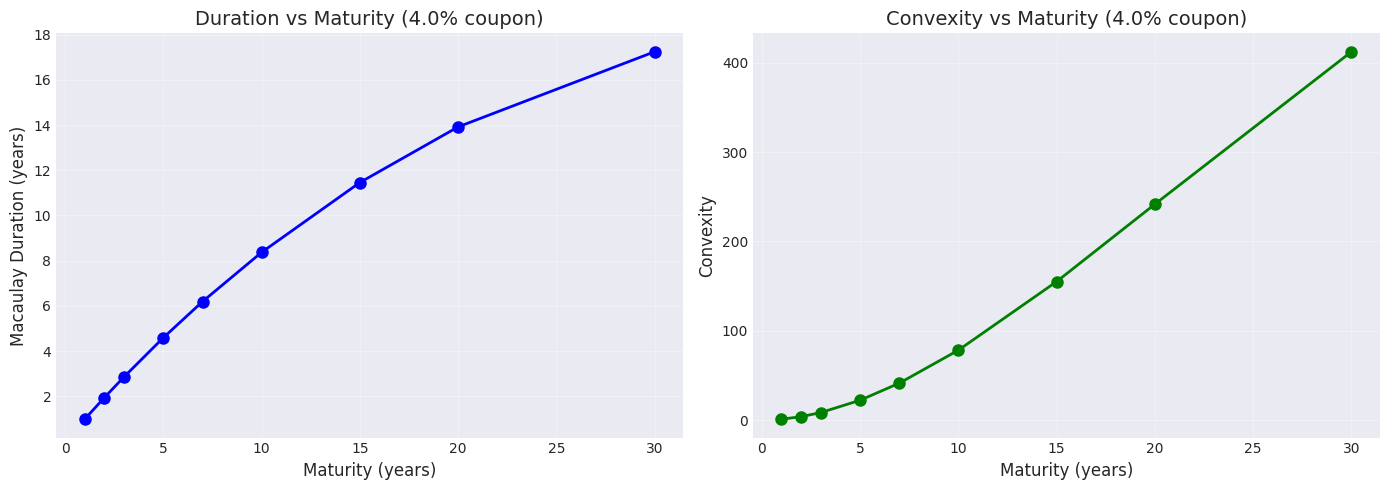

In [10]:
# Visualize duration across maturities
test_maturities = np.array([1, 2, 3, 5, 7, 10, 15, 20, 30], dtype=float)
test_coupon = 0.04  # 4% coupon
test_freq = 2
durations = []
convexities = []

for mat in test_maturities:
    ytm_val = yield_curve.zero_rate(mat)
    cashflows = analytics.generate_cashflows(mat, test_coupon, 100.0, test_freq)
    dur = analytics.macaulay_duration(ytm_val, cashflows)
    conv = analytics.convexity(ytm_val, cashflows)
    durations.append(dur)
    convexities.append(conv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Duration
ax1.plot(test_maturities, durations, "o-", linewidth=2, markersize=8, color="blue")
ax1.set_xlabel("Maturity (years)", fontsize=12)
ax1.set_ylabel("Macaulay Duration (years)", fontsize=12)
ax1.set_title(f"Duration vs Maturity ({test_coupon*100:.1f}% coupon)", fontsize=14)
ax1.grid(True, alpha=0.3)

# Convexity
ax2.plot(test_maturities, convexities, "o-", linewidth=2, markersize=8, color="green")
ax2.set_xlabel("Maturity (years)", fontsize=12)
ax2.set_ylabel("Convexity", fontsize=12)
ax2.set_title(f"Convexity vs Maturity ({test_coupon*100:.1f}% coupon)", fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Discount FactorsDiscount factors are used to present-value future cashflows.

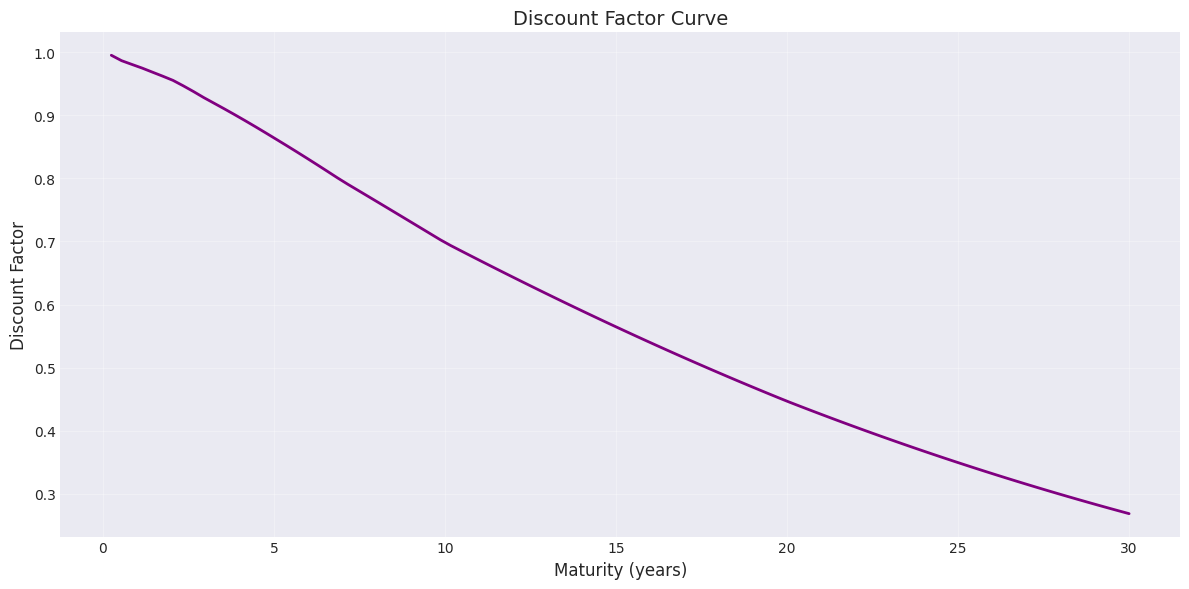


Discount Factors:
Maturity        Discount Factor      Implied Zero Rate   
-------------------------------------------------------
0.50            0.987500             2.516               %
1.00            0.977932             2.232               %
2.00            0.956662             2.215               %
5.00            0.864201             2.919               %
10.00           0.698272             3.591               %
20.00           0.446834             4.028               %
30.00           0.268616             4.382               %


In [11]:
# Calculate and plot discount factors
discount_maturities = np.linspace(0.25, 30, 100)
discount_factors = [yield_curve.discount_factor(m) for m in discount_maturities]

plt.figure(figsize=(12, 6))
plt.plot(discount_maturities, discount_factors, linewidth=2, color="purple")
plt.xlabel("Maturity (years)", fontsize=12)
plt.ylabel("Discount Factor", fontsize=12)
plt.title("Discount Factor Curve", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDiscount Factors:")
print(f"{'Maturity':<15} {'Discount Factor':<20} {'Implied Zero Rate':<20}")
print("-" * 55)
for mat in [0.5, 1, 2, 5, 10, 20, 30]:
    df = yield_curve.discount_factor(mat)
    zr = yield_curve.zero_rate(mat)
    print(f"{mat:<15.2f} {df:<20.6f} {zr*100:<20.3f}%")